# Model Evaluation

In [1]:
import os
import sys
import json
import time
import joblib
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

In [2]:
sys.path.append("../src/")

In [3]:
from utilities import *

In [4]:
pd.set_option("display.max_columns", None)

In [5]:
from sklearn.model_selection import cross_val_score

### Load Data

In [6]:
filepath = os.path.join(dir_dict["train_test"], f"train.parquet")
train = pd.read_parquet(filepath)
filepath = os.path.join(dir_dict["train_test"], f"test.parquet")
test = pd.read_parquet(filepath)

to_drop = ["event_date", "fight_id", "fighter_id", "opponent_id"]
train = train.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

In [7]:
target = "fight_fighter_win"
X_train, y_train = train.drop(target, axis=1), train[target]
X_test, y_test = test.drop(target, axis=1), test[target]

In [9]:
def cross_validate(estimator, X, y, cv=5, **kwargs):
    return np.mean(cross_val_score(estimator, X, y, cv=cv, **kwargs))

### Load Pipelines

In [10]:
pipe = joblib.load("../assets/model_training/trained_pipeline.joblib")

## Evaluation

In [11]:
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score, 
    precision_score,
    recall_score,
    roc_auc_score,
    ConfusionMatrixDisplay
)

In [12]:
def get_metrics_dict_and_confusion_matrix(train_test_label):
    global metrics_dict, pipe
    if train_test_label == "train":
        X, y = X_train, y_train
    elif train_test_label == "test":
        X, y = X_test, y_test
    else:
        raise Exception("Unknown label")
        
    y_pred = pipe.predict(X)
    metrics_dict[(train_test_label, "accuracy")] = accuracy_score(y, y_pred).round(4)
    metrics_dict[(train_test_label, "precision")] = precision_score(y, y_pred).round(4)
    metrics_dict[(train_test_label, "recall")] = recall_score(y, y_pred).round(4)
    metrics_dict[(train_test_label, "f1_score")] = f1_score(y, y_pred).round(4)
    # metrics_dict[(train_test_label, "roc_auc_score")] = roc_auc_score(y, y_pred).round(4)
    
    cm = confusion_matrix(y, y_pred)

    cm_plot = ConfusionMatrixDisplay(cm, display_labels=pipe.classes_)
    cm_plot.plot()
    plt.title(f"Confusion Matrix ({train_test_label.capitalize()} Set)")
    plt.savefig(f"../assets/imgs/{train_test_label}_confusion_matrix.png")
    plt.show()

### Evaluate on Training Data

In [13]:
metrics_dict = dict()

#### Single Model Pipeline

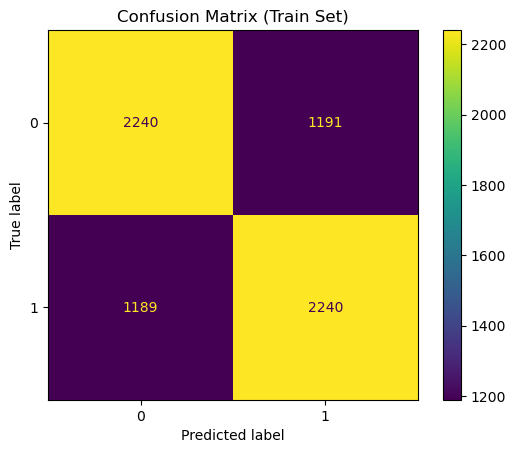

In [14]:
get_metrics_dict_and_confusion_matrix("train")

### Evaluate on Testing Data

#### Single Model Pipeline

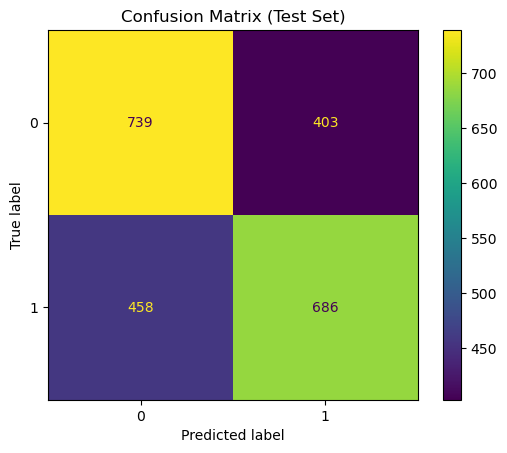

In [15]:
get_metrics_dict_and_confusion_matrix("test")

### Metrics

In [16]:
metrics_df = pd.DataFrame(metrics_dict, index=[0]).stack(level=0).reset_index(0, drop=True).sort_index(ascending=False)
metrics_df

,accuracy,f1_score,precision,recall
train,0.6531,0.6531,0.6529,0.6533
test,0.6234,0.6144,0.6299,0.5997


## Retrain on entire dataset

In [17]:
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

In [19]:
pipe.fit(X, y)
joblib.dump(pipe, "../assets/model_training/trained_pipeline_final.joblib")

['../assets/model_training/trained_pipeline_final.joblib']